1098820.3972122124


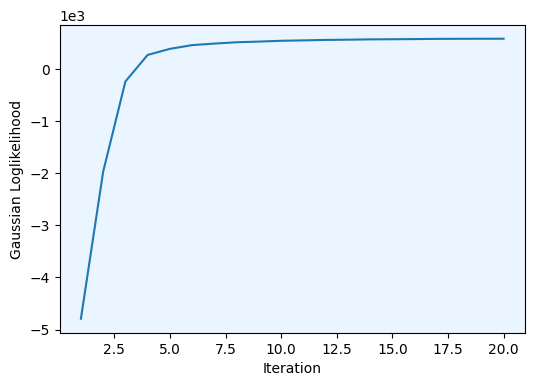

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

data = np.genfromtxt('A2Q1.csv', delimiter=',')
num_mixtures = 4
num_initialisations = 100
num_iterations = 20
num_points, dimensions = data.shape
distant_point = np.array([1e9 for _ in range(dimensions)])

def calculate_distance(point1, point2):
    sep = point1 - point2
    return np.sqrt(np.dot(sep, sep))

def calculate_error(data, means, z):
    error = 0
    for i, point in enumerate(data):
        error += calculate_distance(point, means[z[i]])**2

    return error

def update_means(data, z):
    means = np.zeros((num_mixtures, dimensions), dtype='float64')
    num_cluster_points = np.zeros(num_mixtures)

    for i, point in enumerate(data):
        means[z[i]] += point
        num_cluster_points[z[i]] += 1

    for i, mean in enumerate(means):
        if num_cluster_points[i] != 0:
            mean /= num_cluster_points[i]
        else:
            mean = distant_point 

    return means

def multivariate_gaussian(diff, cov_det, cov_inv):
    exponent = -0.5 * np.sum(np.dot(diff, cov_inv) * diff)
    coeff = 1 / (np.sqrt((2 * np.pi) ** dimensions * cov_det))
    prob = coeff * np.exp(exponent)
    return prob
    
def calculate_data_probab(data, means, covariances):
    probab = np.zeros((num_points, num_mixtures))
    for i, mean in enumerate(means):
        cov_det = abs(np.linalg.det(covariances[i] + 1e-5*np.eye(dimensions)))
        cov_inv = np.linalg.inv(covariances[i] + 1e-5*np.eye(dimensions))
        for j, point in enumerate(data):
            diff = point - mean
            probab[j, i] = multivariate_gaussian(diff, cov_det, cov_inv)    
    return probab
        
def update_lambdas(probab, pii):
    lambdas = np.zeros((num_points, num_mixtures))
    for mixture in range(num_mixtures):
        lambdas[:, mixture] = pii[mixture]*probab[:, mixture]
    lambdas /= np.sum(lambdas, axis=1, keepdims=True)
    return lambdas

def update_means(lambdas, data):
    return np.matmul(lambdas.T, data)/np.sum(lambdas, axis=0)[:, np.newaxis]

def update_covariances(lambdas, means, data):
    num_points, dimensions = data.shape
    num_mixtures = lambdas.shape[1]
    covariances = np.zeros((num_mixtures, dimensions, dimensions))
    
    for mixture in range(num_mixtures):
        diff = data - means[mixture]
        weighted_diff = np.multiply(diff, lambdas[:, mixture][:, np.newaxis])
        covariances[mixture] = np.matmul(weighted_diff.T, diff) / np.sum(lambdas[:, mixture])
    return covariances
    
def update_pii(lambdas):
    return np.sum(lambdas, axis=0)/lambdas.shape[0]

def calculate_log_likelihood(probab, pii):
    likelihood = 0
    for point_probab in probab:
        likelihood += np.log(np.dot(point_probab, pii))
    return likelihood

error = 0
likelihood = np.zeros(num_iterations)
for _ in range(num_initialisations):
    pii = np.random.rand(num_mixtures)
    pii /= np.sum(pii)
    means = np.random.rand(num_mixtures, dimensions)
    lambdas = np.random.rand(num_points, num_mixtures)
    covariances = update_covariances(lambdas, means, data)
    for __ in range(num_iterations):
        probab = calculate_data_probab(data, means, covariances)
        likelihood[__] += calculate_log_likelihood(probab, pii)
        lambdas = update_lambdas(probab, pii)
        pii = update_pii(lambdas)
        means = update_means(lambdas, data)
        covariances = update_covariances(lambdas, means, data)
    z = np.zeros(num_points, dtype='int')
    for i, lamb in enumerate(lambdas):
        z[i] = np.argmax(lamb)

    means = update_means(data, z)
    error += calculate_error(data, means, z)
error /= num_initialisations
likelihood /= num_initialisations

# K-means error by alloting the data points to highest probable cluster
print(error)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(np.linspace(1, num_iterations, num_iterations), likelihood)
ax.set_xlabel("Iteration")
ax.set_ylabel("Gaussian Loglikelihood")
ax.set_facecolor('#ebf5ff')
ax.ticklabel_format(scilimits=(-3, 2))
plt.savefig('images/Q1/Gaussian EM')
plt.show()